In [1]:
import os
import sys

curr_path = !pwd
curr_path = curr_path[0]
curr_path

'/Users/jonathanperalgort/Documents/DL-CMPT420/final_project/src/tests/notebooks'

In [2]:
utils_path = os.path.join(os.path.dirname(curr_path), '..', 'utils/')
utils_path

'/Users/jonathanperalgort/Documents/DL-CMPT420/final_project/src/tests/../utils/'

In [3]:
sys.path.append(utils_path)

In [4]:
import torch 
import torchvision
import numpy as np
from DataLoader import CelebADataset
from PruningHelper import PruningHelper as ph
from HybridResNetVIT import HybridResNetVIT
from torch.utils.data import random_split, DataLoader, Subset

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [6]:
SAMPLE_SEED = 42
K_FOLDS = 4
EPOCHS = 1

BATCH_SIZE = 64

In [7]:
data_path = os.path.join(os.path.dirname(curr_path), '..', '..', 'dataset/')
img_path = os.path.join(os.path.dirname(data_path), 'Img', 'img_align_celeba')
anno_path = os.path.join(os.path.dirname(data_path), 'Anno', 'list_attr_celeba.txt')
img_path, anno_path

('/Users/jonathanperalgort/Documents/DL-CMPT420/final_project/src/tests/../../dataset/Img/img_align_celeba',
 '/Users/jonathanperalgort/Documents/DL-CMPT420/final_project/src/tests/../../dataset/Anno/list_attr_celeba.txt')

In [8]:
dataset = CelebADataset(img_path, anno_path)

In [9]:
TOTAL_SIZE = len(dataset)
TOTAL_SIZE

202599

### Dataset split:

In [10]:
SAMPLE_SIZE = 1000

In [11]:
test_size = int(0.1 * SAMPLE_SIZE)
train_size = int(SAMPLE_SIZE - test_size)

# Generator
generator = torch.Generator().manual_seed(SAMPLE_SEED)

# Data Sampling
sample_indices = torch.randperm(len(dataset))[:SAMPLE_SIZE]
ds_sample = Subset(dataset, sample_indices)
ds_train, ds_test = random_split(ds_sample, [train_size, test_size], generator=generator)
print(f"[Sampling] Train size: {len(ds_train)}, Test size: {len}")
# -----------End sampling ---------------

[Sampling] Train size: 900, Test size: <built-in function len>


In [12]:
train_loader = DataLoader(ds_train, batch_size=BATCH_SIZE, shuffle=False)

In [13]:
from ModelUtils import ModelUtils
mu = ModelUtils(device)

### Initializing model

In [ ]:
models_path = os.path.join(os.path.dirname(curr_path), '..', '..', 'models', 'test_models/')
models_path

'/Users/jonathanperalgort/Documents/DL-CMPT420/final_project/src/tests/../../models/test_models/'

In [ ]:
pruned_resnet = torch.load(f"{models_path}/pruned_model_04_06_2025_18_04.pth", weights_only=False)
pruned_resnet

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential()
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_

In [37]:
full_model = torch.load(f"{models_path}/full_model_04_06_2025_18_04.pth", weights_only=False)

In [38]:
test_loader = DataLoader(ds_test, batch_size=BATCH_SIZE, shuffle=False)

In [39]:
mu.test_model(pruned_resnet, test_loader)

Test Evaluation
Accuracy: 0.91
Test precision: 0.90
Test recall: 0.53
Test f1-score: 0.67
Finished test evaluation!


In [40]:
test_cie = mu.get_cie_count(full_model, pruned_resnet, test_loader)

Determining CIEs:
Number of CIEs: 43


In [18]:
# Freeze resnet params
resnet_params = 0
for param in pruned_resnet.parameters():
    param.requires_grad = False
    resnet_params += 1
resnet_params

62

### Initialization of ViT Hybrid

In [19]:
model = HybridResNetVIT(resnet=pruned_resnet, num_layers=2)

In [20]:
total_param = 0
active_param = 0
for p in model.parameters():
    if p.requires_grad:
        active_param +=1
    total_param += 1

# Only those from the VIT encoder should be active total - 60.
total_param, active_param

(86, 26)

In [21]:
optimizer = torch.optim.AdamW(
    [p for p in model.parameters() if p.requires_grad],
    lr=0.001
)

In [22]:
vit_pruned, vit_loss, vit_accuarcy, vit_precision, vit_recall, vit_f1_score = mu.trainer(model, optimizer, ds_train, K_FOLDS, BATCH_SIZE, EPOCHS)

Fold: 1, Epoch: [1/1], Loss: 0.6323047
Fold: [1/4], Accuracy: 0.8266666666666667, Precision: 0.00, Recall: 0.00, F1-Score: 0.00
Fold: 2, Epoch: [1/1], Loss: 0.3313214
Fold: [2/4], Accuracy: 0.9244444444444444, Precision: 0.63, Recall: 0.76, F1-Score: 0.69
Fold: 3, Epoch: [1/1], Loss: 0.2530755
Fold: [3/4], Accuracy: 0.88, Precision: 0.87, Recall: 0.34, F1-Score: 0.49
Fold: 4, Epoch: [1/1], Loss: 0.2790581
Fold: [4/4], Accuracy: 0.9111111111111111, Precision: 0.72, Recall: 0.72, F1-Score: 0.72
Avg. accuracy: 0.89
Avg. precision: 0.56
Avg. Recall: 0.46
Avg. F1-score: 0.48
Training Completed
Number of steps 44


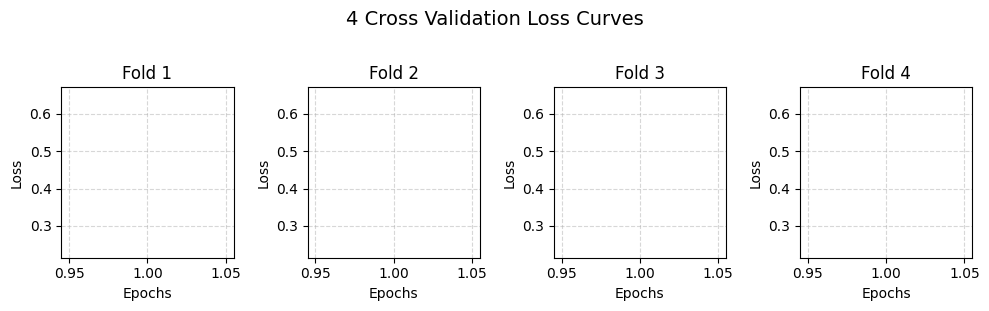

In [23]:
mu.plot_loss_curves(vit_loss, K_FOLDS, EPOCHS)

In [24]:
ph.get_sparsity(vit_pruned)

63.26564193313163

In [25]:
mu.test_model(vit_pruned, test_loader)

Test Evaluation
Accuracy: 0.96
Test precision: 0.84
Test recall: 0.94
Test f1-score: 0.89
Finished test evaluation!


In [30]:
from datetime import datetime

current_time = datetime.now().strftime("%m_%d_%Y_%H_%M")
torch.save(vit_pruned, f'{models_path}/vit_pruned_{current_time}.pth')